In [1]:
import pandas as pd 
import numpy as np
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
from dotenv import load_dotenv # used to load env variables
load_dotenv()

True

In [3]:
# DB Configuration (Assuming you already have this)
DB_CONFIG = {
    'dbname': 'emails_db',
    'user': 'alexanderbarriga03',
    'password': 'water03',
    'host': 'localhost',
    'port': '5432'
}

def get_emails_from_db():
    # Retrieve vector from PostgreSQL and decode it
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()

    cursor.execute("SELECT * FROM emails")
    emails = cursor.fetchall()

    data = []
    for email in emails:
        emails_dict = {}
        emails_dict['id'] = email[0]
        emails_dict['sender'] = email[1]
        emails_dict['subject'] = email[2]
        emails_dict['timestamp'] = email[3]
        emails_dict['body'] = email[4]
        emails_dict['body_vector'] = np.frombuffer(email[5], dtype=np.float32)
        data.append(emails_dict)

    cursor.close()
    conn.close()
    
    return data

In [4]:
load_emails = get_emails_from_db() # load emails from db
len(load_emails)

1086

In [22]:
df = pd.DataFrame(load_emails)
df.timestamp = pd.to_datetime(df.timestamp)
df["body"] = df["body"].astype("string")  
#df["body_vector"] = df["body_vector"].apply(lambda x: np.array(x))
df["date"] = df["timestamp"].dt.date

df.head()

,id,sender,subject,timestamp,body,body_vector,date
0,8,Meetup <info@meetup.com>,Amelia Mink posted in Data Science for Sustain...,2025-02-17 23:31:19-08:00,Amelia Mink posted in Data Science for Sustain...,"[0.007864882, 0.021925885, 0.049149904, -0.010...",2025-02-17
1,9,Gargi K Kand <gargikand@user.luma-mail.com>,You are invited to Gen Z Founders Meetup 💃🎉,2025-02-17 23:00:46-08:00,You’re invited toGen Z Founders Meetup 💃🎉Tuesd...,"[-0.027701547, 0.0310088, -0.010775029, 0.0235...",2025-02-17
2,10,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,“data scientist”: Jobot - Data Scientist and more,2025-02-17 22:57:28-08:00,Your job alert for data scientist in Berkeley6...,"[-0.035555333, -0.022728117, 0.0257007, 0.0118...",2025-02-17
3,11,Gargi K Kand <noreply@luma-mail.com>,Vently's Wellness Block Party!,2025-02-17 21:54:53-08:00,"[ Block Party (Vently x SF Social Club)Feb 23,...","[-0.02093746, -0.018726151, 0.0027641365, 0.03...",2025-02-17
4,12,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,“data scientist”: Eczacıbaşı Bilişim - DATA SC...,2025-02-17 20:57:26-08:00,Your job alert for data scientist30+ new jobs ...,"[-0.035098318, -0.017927919, 0.027132906, 0.00...",2025-02-17


In [23]:
# agg emails received by day for plotting
email_daily_count = df.groupby("date").size().to_frame()
email_daily_count.rename({0:'daily_email_count'}, axis=1, inplace=True)

In [24]:
# Interactive Plotly plot
fig = px.line(email_daily_count, 
              x=email_daily_count.index,
              y="daily_email_count", 
              markers=True, 
              title="Interactive Emails Per Day", 
              labels={"email_count": "Number of Emails"})

fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Email Count")

fig.show();

In [41]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA

X = np.vstack(df.body_vector.values)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

# Create a new DataFrame for visualization
df_pca = pd.DataFrame(X_reduced, columns=["PC1", "PC2", "PC3"])
df_pca["email_id"] = df.index  # Assign unique IDs
df_pca["PC1_magnitude"] = df_pca["PC1"].abs() 

# Plot 3D scatter using Plotly
fig = px.scatter_3d(df_pca, x="PC1", y="PC2", z="PC3", 
                     color=df_pca.PC1_magnitude,  # Color by email index
                     title="3D PCA of Email Embeddings",
                     labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2", "PC3": "Principal Component 3"},
                     opacity=0.8)

fig.show()

In [43]:
## no obvious clusters appear in either 2D or 3D plot 


# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Create a new DataFrame for visualization
df_pca = pd.DataFrame(X_reduced, columns=["PC1", "PC2"])
df_pca["email_id"] = df.index  # Assign unique IDs
df_pca["PC1_magnitude"] = df_pca["PC1"].abs()  # Color by the magnitude of PC1

# Plot 2D scatter using Plotly
fig = px.scatter(df_pca, x="PC1", y="PC2", 
                # color="PC1_magnitude",  # Color by magnitude of PC1
                 title="2D PCA of Email Embeddings",
                 labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"},
                 opacity=0.8)

fig.show()


#### Observations 
It's difficult to visually detect any clear cluster boundaries. Perhaps one could say that there are 3 clusters: 2 small ones at the ends and a large one in the middle. However I can verify that there are more than 3 categories of emails in my gmail inbox. 

### GPT Generated Email Categories
Since no clear cluster boundaries appear, let's use a GPT model to generate email category labels for us. 

In [44]:
from openai import OpenAI
client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[{
        "role": "user",
        "content": "Write a one-sentence bedtime story about a unicorn."
    }]
)

print(completion.choices[0].message.content)

Under the gentle glow of the moon, a shimmering unicorn named Luna soared across the starlit sky, weaving dreams of magic and wonder for all the children sleeping below.


In [62]:
from openai import OpenAI

def categorize_emails(email_texts):
    client = OpenAI()

    messages = [
        {
            "role": "system",
            "content": """ 
            Analyze the email body text and output a simple category label for that email. 
            You will be analyzing hundreds of emails so you'll want to re-use the same labels for similar emails.
            For example a LinkedIn email about a job posting and an Indeed email about a job posting should likely be givin the same label, 
            such as Job Posting. But look at the context of each email carefully to generate a label that accurately represents the content of the email.  
            """
        }
    ]

    results = []
    
    for email in email_texts:
        #messages.append({"role": "user", "content": f"Categorize this email: {email}"})

        completion = client.chat.completions.create(
            model="gpt-4o",
            messages=messages
        )

        category = completion.choices[0].message.content.strip()
        results.append({"email": email, "category": category})

        # Clear messages to avoid context buildup
        #messages = messages[:1]

    return results


categorized_emails = categorize_emails(df.body[:3])

InternalServerError: Error code: 500 - {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}}

In [60]:
results = []

for email in df.body[:3]:
    messages.append({"role": "user", "content": f"Categorize this email: {email}"})

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=messages
    )

    category = completion.choices[0].message.content.strip()
    results.append({"email": email, "category": category})

    # Clear messages to avoid context buildup
    messages = messages[:1]

NameError: name 'messages' is not defined

In [59]:
for i in df.body[:3]:
    print(i)
    break

Amelia Mink posted in Data Science for SustainabilityAmelia Mink started a discussion in Data Science for Sustainability.Amelia Mink More AI, More Spending? Let’s Change ThatScaling AI shouldn’t mean skyrocketing costs.Discover how to cut inefficiencies & boost performance in this live session on Feb 19 at 2PM ET.🔗 Reserve your spot View discussionUnsubscribe from these type of emails. Manage your Email Notification Preferences. Read our Privacy Policy. Meetup LLC, POB 4668 #37895 New York NY USA 10163.


In [69]:
len(df.body[1000])

3745

In [70]:
len(["".join(("",txt))for txt in df.body])

1086

In [78]:
def categorize_email(email_text):
    client = OpenAI()

    label_email_prompt =f""" 
        Analyze the email body text and output a simple category label for that email. 
        You will be analyzing hundreds of emails so you'll want to re-use the same labels for similar emails.
        For example a LinkedIn email about a job posting and an Indeed email about a job posting should likely be givin the same label, 
        such as Job Posting. But look at the context of each email carefully to generate a label that accurately represents the content of the email.  
        Only output the category label. 
        
        Categorize Email: {email_text}
    """

    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": label_email_prompt}]
    )

    return completion.choices[0].message.content

# Apply summarization before categorization
labels = [categorize_email(email) for email in df.body]

In [81]:
df['category'] = labels

In [83]:
labels

['Event Announcement',
 'Event Invitation',
 'Job Posting',
 'Event Announcement',
 'Job Posting',
 "I'm sorry, but there is no email text to analyze currently. Please provide the email body text you need categorized.",
 'Networking Suggestion',
 'Event Reminder',
 'Event Reminder',
 'Personal Development Training',
 'Event Announcement',
 'Event Invitation',
 'Job Posting',
 'Promotional Offer',
 'Event Promotion',
 'Job Posting',
 "I'm sorry, but it seems there is no email text provided for me to categorize. Please provide the email body text for analysis.",
 'Event Invitation',
 'Event Reminder',
 'Personal Development Workshop',
 'Event Reminder',
 'Job Posting',
 'Event Update',
 'News and Promotions',
 'Online Learning Courses',
 'Profile View Notifications',
 'Job Posting',
 'Job Posting',
 'Newsletter Subscription',
 'Event Invitation',
 'Notification Alert',
 'Local News Update',
 'Billing Notification',
 'Job Application Acknowledgment',
 'Music Promotion',
 'Technology Innov

In [ ]:
# remove the empty emails 
mask = df.body != ""
df = df[mask]

In [95]:
df.head()

,id,sender,subject,timestamp,body,body_vector,date,category
0,8,Meetup <info@meetup.com>,Amelia Mink posted in Data Science for Sustain...,2025-02-17 23:31:19-08:00,Amelia Mink posted in Data Science for Sustain...,"[0.007864882, 0.021925885, 0.049149904, -0.010...",2025-02-17,Event Announcement
1,9,Gargi K Kand <gargikand@user.luma-mail.com>,You are invited to Gen Z Founders Meetup 💃🎉,2025-02-17 23:00:46-08:00,You’re invited toGen Z Founders Meetup 💃🎉Tuesd...,"[-0.027701547, 0.0310088, -0.010775029, 0.0235...",2025-02-17,Event Invitation
2,10,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,“data scientist”: Jobot - Data Scientist and more,2025-02-17 22:57:28-08:00,Your job alert for data scientist in Berkeley6...,"[-0.035555333, -0.022728117, 0.0257007, 0.0118...",2025-02-17,Job Posting
3,11,Gargi K Kand <noreply@luma-mail.com>,Vently's Wellness Block Party!,2025-02-17 21:54:53-08:00,"[ Block Party (Vently x SF Social Club)Feb 23,...","[-0.02093746, -0.018726151, 0.0027641365, 0.03...",2025-02-17,Event Announcement
4,12,LinkedIn Job Alerts <jobalerts-noreply@linkedi...,“data scientist”: Eczacıbaşı Bilişim - DATA SC...,2025-02-17 20:57:26-08:00,Your job alert for data scientist30+ new jobs ...,"[-0.035098318, -0.017927919, 0.027132906, 0.00...",2025-02-17,Job Posting


In [ ]:
df.category.value_counts()

category
Event Invitation                 138
Job Posting                      128
Promotional Offer                 50
Event Reminder                    31
Newsletter                        30
                                ... 
AI and Technology Newsletter       1
Personal Development Training      1
Credit Monitoring Update           1
Event/Community Update             1
Event Update                       1
Name: count, Length: 409, dtype: int64

In [ ]:
len(df.category.unique()) # number of unique email categories 

409

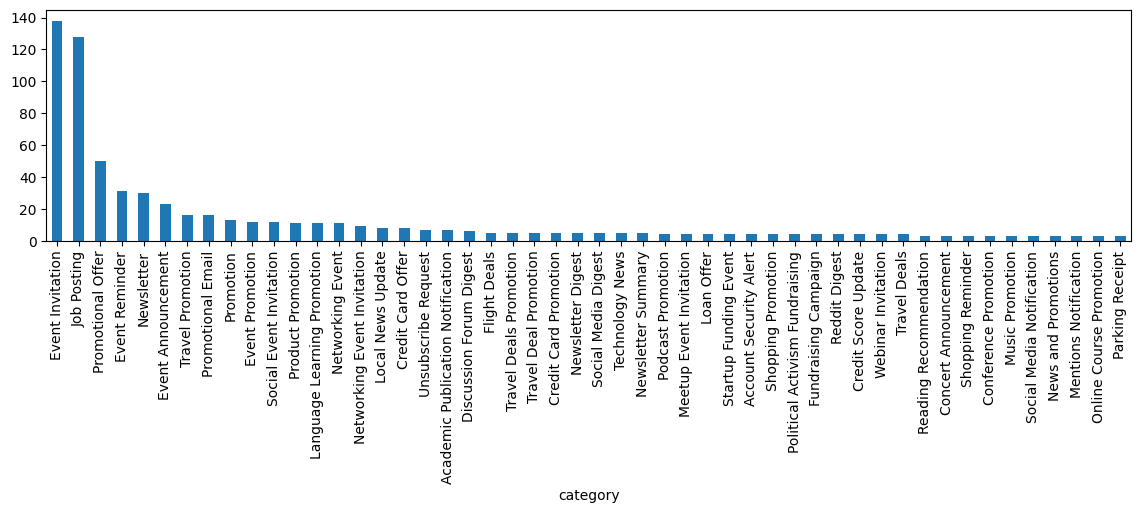

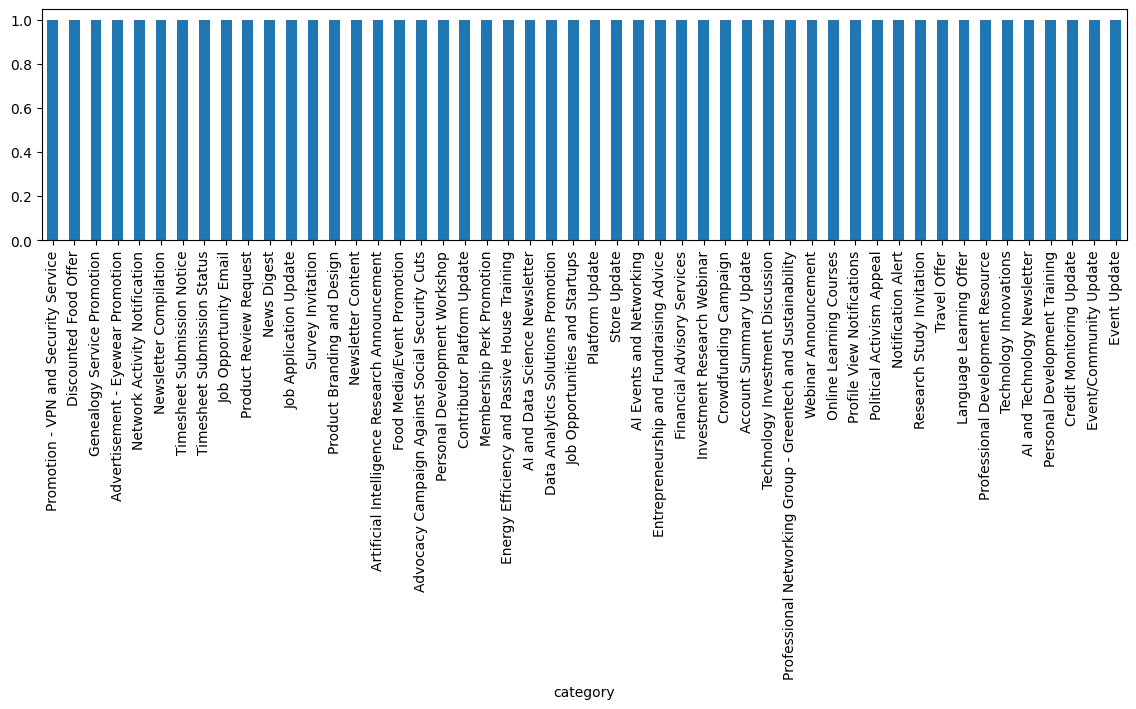

In [109]:
n = 50
title = "Top {} Email Categories ".format(n)
df.category.value_counts()[:n].plot(kind='bar', figsize=(14,3))
plt.show();
    

title = "Bottom {} Email Categories ".format(n)
df.category.value_counts()[-n:].plot(kind='bar', figsize=(14,3))
plt.show();

#### Observations
- This approach doesn't work, we can't have half as many category labels as we have emails 
- We need to find a way to pass into global context of emails while staying within token limits 